# Principle of Simulation - Final Project

`Farid Mohammadzadeh - 40025073` \
`Amirhossein Reza Gharebagh - 40025024`\
`Hessam Ebrahimi - 9925076`

In [2]:
import numpy as np
import random
import scipy.stats as st
from scipy.stats import t
import matplotlib.pyplot as plt
import pandas as pd

# Random Number Generation

In [3]:
def Rand_num_gen(a, m, X0, c):
    return (a * X0 + c) % m

flag = True
#The first number of the sequnce - X0
randnum = [1]
while(flag): # a = 5, m = 2 ** 20, X0 = 1, c = 3
    r = Rand_num_gen(5 , 2 ** 20  , randnum[-1], 3)
    if(r != 1): #Check whether we entered the loop or not
        randnum.append(r)
    else:
        flag = False

randnum = np.array(randnum) / (2 ** 20) #Scaling random numbers - [0,1]
randnum = list(randnum)
print(f"{len(randnum)} random numbers have been generated")
print(randnum[:5])
print(f'The maximum Ri: {max(randnum)} \nThe minimum Ri: {min(randnum)}')

1048576 random numbers have been generated
[9.5367431640625e-07, 7.62939453125e-06, 4.100799560546875e-05, 0.0002079010009765625, 0.0010423660278320312]
The maximum Ri: 0.9999990463256836 
The minimum Ri: 0.0


In [4]:
#Uniformity Test 
def uniformity_test(sample_random): #Kolmogorov-smirnov test
    N = len(sample_random)
    sorted_rnd = sorted(sample_random)
    D_plus = []
    D_minus = []
    
    for i in range(N):
        D_plus.append((i + 1) / N - sorted_rnd[i])
        D_minus.append(sorted_rnd[i] - i / N)
        
    D = max(max(D_plus) , max(D_minus))
    critical_value = 1.63 / np.sqrt(N) #alpha = 0.01
    print(f'D is {D}\ncritical value is {critical_value}')
    if D > critical_value:
        print('Reject Null Hypothesis')
    else: print('Not Enough Evidence to Reject The Null Hypothesis')

#Independency Test 
def independency_test(sample_random):
    N = len(sample_random)
    M = N - 2 #N stars from 0 -> M = N-2

    rho_hat = np.sum([(sample_random[i] * sample_random[i + 1]) for i in range(N - 1)])/(M + 1) - 0.25 #checking the ind-test for lag 1
    sigma_hat = ((13 * M + 7) ** 0.5)/(12 * (M + 1))
    Z = rho_hat / sigma_hat
    print(f'rho_hat = {rho_hat}\nsigma_hat = {sigma_hat}\nZ = {Z}')

    pval = st.norm.sf(abs(Z)) * 2 #two-tailed
    print(f'p-value is {pval}')
    if pval <= 0.01: #alpha = 0.01
        print('Reject Null Hypothesis')
    else: 
        print('Not Enough Evidence to Reject The Null Hypothesis')

In [604]:
sample_random = random.sample(list(randnum),1000000)
print(sample_random[:5])

[0.3954353332519531, 0.588627815246582, 0.5995082855224609, 0.4190807342529297, 0.9690647125244141]


In [605]:
#Tests Results
print('Results for Uniformity Test:')
uniformity_test(sample_random)
print('\n\nResults for Independency Test: ')
independency_test(sample_random)

Results for Uniformity Test:
D is 0.00020537866210934563
critical value is 0.00163
Not Enough Evidence to Reject The Null Hypothesis


Results for Independency Test: 
rho_hat = -0.00012799545279196245
sigma_hat = 0.00030046268718244505
Z = -0.42599450198700334
p-value is 0.6701118522712918
Not Enough Evidence to Reject The Null Hypothesis


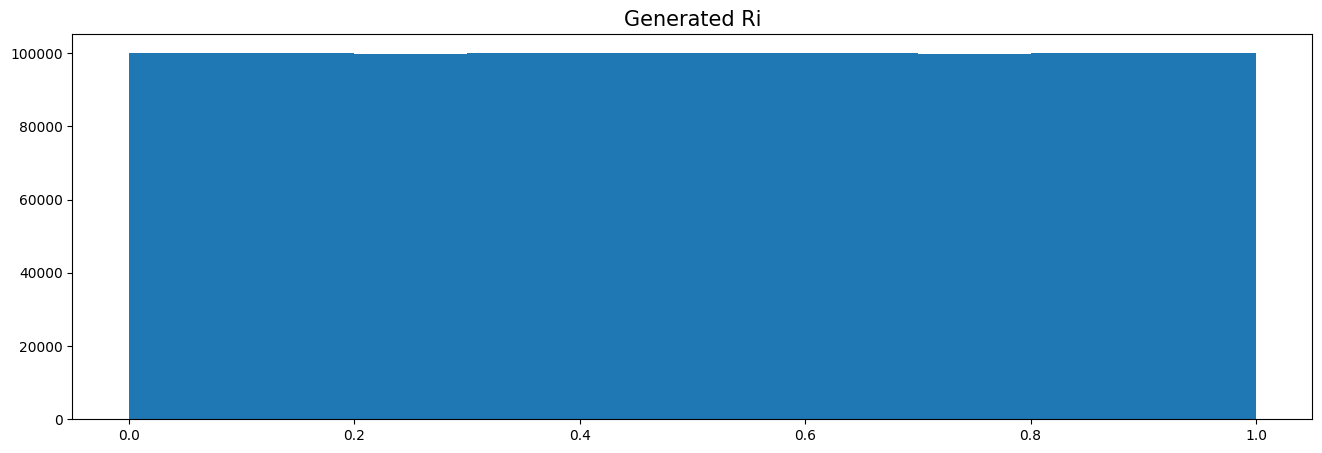

In [606]:
plt.figure(figsize = (16, 5))
plt.title('Generated Ri', fontsize = 15)
plt.hist(sample_random)
plt.show()

# Random Variates Generation

#### Function for generating normal random variates

In [941]:
def normal_generator(r1, r2, mu, sigma): #Direct-Trasform Technique
    Z = ((-2 * np.log(r1)) ** 0.5) * np.sin(2 * math.pi * r2)
    X = mu + sigma * Z
    return X

In [336]:
# print(normal_generator(sample_random[1], sample_random[2], 12, 5))
# sample_random = sample_random[1:]
# normal_generator(sample_random[1], sample_random[2], 12, 5)

# Simulation

## Part B

### Initialization 

In [492]:
wait_lst = [] #list for computing waiting time
Nm = 0 #number of people served by first server
Nk = 0 #number of people served by second server
SVRm = 0 #total service time of first server
SVRk = 0 #total service time of second server
Sm = 0 #state of first server
Sk = 0 #state of second server
Nmw = 0 #number of tools recieved by second server(morad)
Nkw = 0 #number of tools recieved by second server(keykavoos)
Q1 = 0 #people in queue for borrowing and returning
Q2 = 0 #line of maintenance
Qw = 0 #number of people waited in line_1 in simulation
Qw2 = 0 #number of people waited in line_2 in simulation
TWT = 0 #total waiting time
ML = 0 #total people came in system for borrow
MR = 0 #total people came in system for Returning
history = [] #using for visualizing
Tnow = 0
T1 = 10 * 60 #The time of simulation
T2 = 11 * 60 #The time everybode leavs
Q = 0 #the number of tools in warehouse at the end of the day
Total_wt_for_return = 0 #total waiting time in the queue for returning 
Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 

In [614]:
fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), \
       (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30)))] #initialization of FEL
fel

[(1, 3.665390943008294), (2, 56.68110701351635)]

### Main events

In [1034]:
#Code 1
def entering_system_for_borrowing(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    ML += 1
    fel.append((1, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30)))) #computing A_star (the next entering)
    sample_random = sample_random[1:]
    if Sm == 0: #enterring first server - Morad
        checker_1 = 1        
        Sm = 1 #changing to bussy
        Nm += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time 
        sample_random = sample_random[1:]
        SVRm += ST #total amount of service
        ABT_lst_m.append(ST)
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    elif Sk == 0:
        checker_2 = 1     
        Sk = 1 #changing to bussy
        Nk += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 14, 4)) #computing service time 
        sample_random = sample_random[1:]
        SVRk += ST #total amount of service
        ABT_lst_k.append(ST)
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return 
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(1) #adding to the list for computing Q2
        wait_lst.append(imn_event)  # job_type = 1 -Code-
        return
    
#Code 2
def entering_system_for_returning(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m   
    MR += 1
    fel.append((2, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30)))) #computing A_star (the next entering)
    sample_random = sample_random[1:]
    if Sm == 0: #enterring first server - Morad
        checker_1 = 2
        Sm = 1 #changing to bussy
        Nm += 1 #number of services
        ST = 2 #computing service time 
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return   
    elif Sk == 0:
        checker_2 = 2        
        Sk = 1 
        Nk += 1 #number of service    
        ST = 2 #computing service time 
        SVRk += ST #total amount of service 
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(2) #adding to the list for computing Q2
        wait_lst.append(imn_event) # job_type = 2 -Code-
        return

#Code 3
def service_end_morad(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if checker_1 == 2:  #using checker for computing Q2
        Q2 += 1   
    if Q1 > 0:
        if checker_lst.pop(0) == 2:
            checker_1 = 2
        else:
            checker_1 = 1
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1        
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if WT > 5:
            p_counter += 1            
        if code == 1:
            Total_wt_for_borrow += WT            
        elif code == 2:
            Total_wt_for_return += WT       
        Nm += 1 #number of services
        if code == 1:
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time
            sample_random = sample_random[1:]
            ABT_lst_m.append(ST)
        elif code == 2:
            ST = 2
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    else:
        Sm = 0
        return      

#Code 4
def service_end_keykavoos(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if checker_2 == 2:
        Q2 += 1 
    if Q1 > 0:
        if checker_lst.pop(0) == 2:
            checker_2 = 2
        else:
            checker_2 = 1  
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1        
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if WT > 5:
            p_counter += 1
        if code == 1:
            Total_wt_for_borrow += WT
        elif code == 2:
            Total_wt_for_return += WT
        Nk += 1 #number of services
        if code == 1:
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 14, 4)) #computing service time
            sample_random = sample_random[1:]
            ABT_lst_k.append(ST)
        elif code == 2:
            ST = 2
        SVRk += ST #total amount of service
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return
    elif Q2 > 0:
        Qw2 += 1 #number of people waited in line in simulation
        Q2 -= 1
        Nkw += 1
        
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
        sample_random = sample_random[1:]
        AMT_lst.append(ST)
        SVRk += ST #total amount of service
        fel.append((5, ST + Tnow)) #adding finish event to fel
        return
    else:
        Sk = 0
        return    

#Code 5
def service_end_warehouse(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if Q2 > 0:
        Nkw += 1
        Qw2 += 1 #number of people waited in line in simulation
        Q2 -= 1  
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
        sample_random = sample_random[1:]
        AMT_lst.append(ST)
        SVRk += ST #total amount of service
        fel.append((5, ST + Tnow)) #adding finish event to fel
        return
    elif Q1 > 0:      
        if checker_lst.pop(0) == 2:
            checker_2 = 2
        else:
            checker_2 = 1  
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1
        
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if WT > 5:
            p_counter += 1
            
        if code == 1:
            Total_wt_for_borrow += WT
        elif code == 2:
            Total_wt_for_return += WT
            
        Nk += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 14, 4)) #computing service time
        sample_random = sample_random[1:]
        ABT_lst_k.append(ST)
        SVRk += ST #total amount of service
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return
    else:
        Sk = 0 
        return    
    
#Code 6
def service_warehouse_after_six_keykavoos(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    Nkw += 1
    Qw2 += 1 #number of people waited in line in simulation
    Q2 -= 1
    ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
    sample_random = sample_random[1:]
    AMT_lst.append(ST)
    SVRk += ST #total amount of service
    fel.append((6, ST + Tnow)) #adding finish event to fel
    return    

#Code 7
def service_warehouse_after_six_morad(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    Nmw += 1
    Qw2 += 1 #number of people waited in line in simulation
    Q2 -= 1
    ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
    sample_random = sample_random[1:]
    AMT_lst.append(ST)
    SVRm += ST #total amount of service
    fel.append((7, ST + Tnow)) #adding finish event to fel
    return    

## Simulating for one day

In [1035]:
p_counter = 0 #variable for handeling people who return and people who borrow
wait_lst = [] #list for computing waiting time
checker_lst = [] #list for computing Q2
ABT_lst_m = [] #list for computing average borrowing time
ABT_lst_k = [] #list for computing average borrowing time
AMT_lst = [] #list for computing average maintenance time 
Nm = 0 #number of people served by first server
Nk = 0 #number of people served by second server
SVRm = 0 #total service time of first server(morad)
SVRk = 0 #total service time of second server(keykavoos)
Sm = 0 #state of first server
Sk = 0 #state of second server
Nmw = 0 #number of tools recieved by second server(morad)
Nkw = 0 #number of tools recieved by second server(keykavoos)
Q1 = 0 #people in queue for borrowing and returning
Q2 = 0 #line of maintenance
Qw = 0 #number of people waited in line in simulation
Qw2 = 0 #number of people waited in line in simulation
TWT = 0 #total waiting time 
ML = 0 #total people came in system for borrow
MR = 0 #total people came in system for Returning
history = [] #using for visualizing
Tnow = 0
T1 = 10 * 60 #The time of simulation
T2 = 11 * 60 #The time everybode leavs
Q = 0 #the number of tools in warehouse at the end of the day
Total_wt_for_return = 0 #total waiting time in the queue for returning 
Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 

i = 1
import time
start_time = time.time()

fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), 
       (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30))),
       (5, 0)] #initialization of FEL
sample_random = sample_random[4:]
Q2 = Q
len_queue = []

while True: #simulation for day {i = 1}
    fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
    imn_event = fel.pop() #finding the imninent event
    Tnow = imn_event[1] #advancing simulation clock
    len_queue.append(Q1) #computing max len queue 
    history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
    if Tnow > T1: #simulation after 6 o'clock
        fel = []
        fel = [(6, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52)))), 
               (7, Tnow + np.abs(normal_generator(sample_random[3], sample_random[4], 16, np.sqrt(52))))] # initialization of FEL
        sample_random = sample_random[4:]
        while True:
            fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
            imn_event = fel.pop() #finding the imninent event
            Tnow = imn_event[1] #advancing simulation clock
            history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
            if Tnow > T2 or Q2 == 0: #Finishing the simulation
                Q = Q2
                print(f'the maximum people in queue: {max(len_queue)}')
                break
            if imn_event[0] == 6:
                service_warehouse_after_six_morad(Tnow, imn_event)
            elif imn_event[0] == 7:
                service_warehouse_after_six_keykavoos(Tnow, imn_event)
        break
    elif imn_event[0] == 1:
        entering_system_for_borrowing(Tnow, imn_event)    
    elif imn_event[0] == 2:
        entering_system_for_returning(Tnow, imn_event)    
    elif imn_event[0] == 3:
        service_end_morad(Tnow, imn_event)
    elif imn_event[0] == 4:
        service_end_keykavoos(Tnow, imn_event) 
    elif imn_event[0] == 5:
        service_end_warehouse(Tnow, imn_event)
        
end_time = time.time()
print(f'\nThe simulation took {end_time-start_time} seconds')

the maximum people in queue: 1

The simulation took 3.0576024055480957 seconds


In [1025]:
print(MR)
print(ML)
print(Total_wt_for_borrow)
print(Total_wt_for_return)

18
21
5.335074864908293
5.561454871623766


[12.070876452036881, 12.77952904603075, 15.377422727920488, 7.033428358085166]

In [900]:
print(Nmw)
print(Nkw)
print(Q2)
print(Tnow)
11 * 60
print(f'SVRk: {SVRk}, SVRm: {SVRm}')

0
14
0
625.3824425078462
SVRk: 275.88482306891194, SVRm: 184.5456160949607


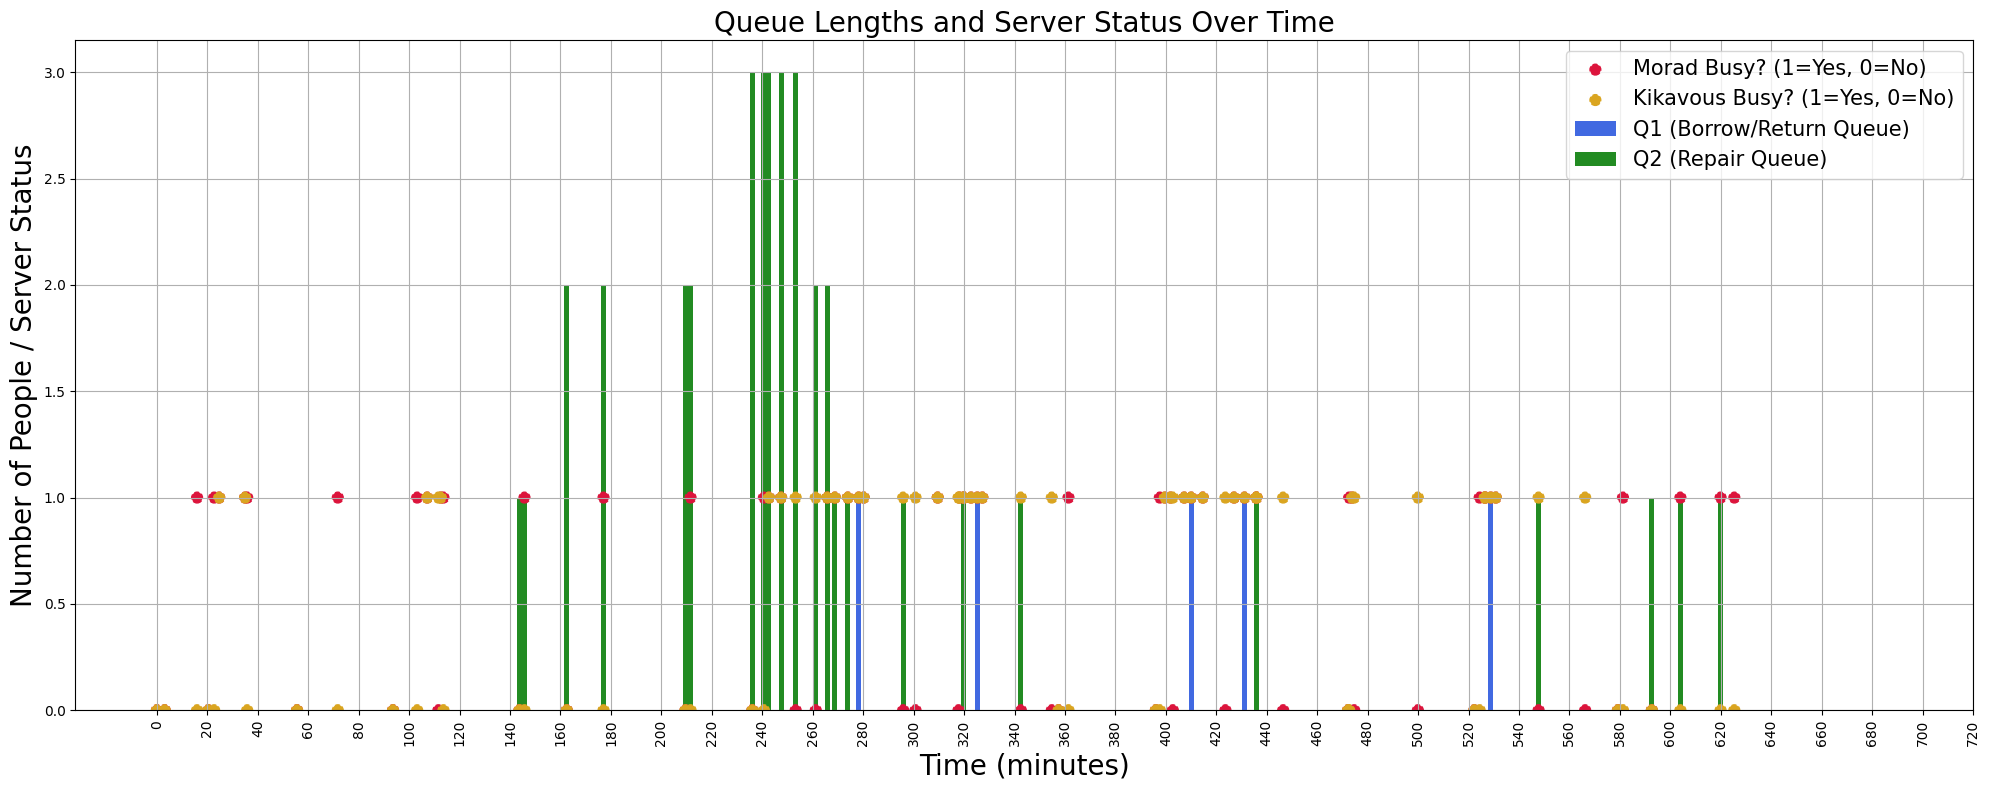

In [928]:
import matplotlib.pyplot as plt
# Extracting values from history
times = [h[0] for h in history]
q1_list = [h[1] for h in history]
q2_list = [h[2] for h in history]
sm_list = [h[3] for h in history]
sk_list = [h[4] for h in history]

plt.figure(figsize=(20, 8))
plt.bar(times, q1_list, label = "Q1 (Borrow/Return Queue)", color = "RoyalBlue", width = 2, alpha = 1)
plt.bar(times, q2_list, label = "Q2 (Repair Queue)", color = "forestgreen", width = 2, alpha = 1)
plt.scatter(times, sm_list, label = "Morad Busy? (1=Yes, 0=No)", color = "crimson", linestyle = "--", s=60)
plt.scatter(times, sk_list, label = "Kikavous Busy? (1=Yes, 0=No)", color = "goldenrod", linestyle = "--", s=60)
plt.xlabel("Time (minutes)", fontsize = 20)
plt.xticks(ticks = range(0, 730, 20),
           labels = range(0, 730, 20),
           rotation = 90)
plt.ylabel("Number of People / Server Status", fontsize = 20)
plt.title("Queue Lengths and Server Status Over Time", fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.show()

In [1015]:
#Creating a list for 30-day simulation
#Average Waiting Time 
AWT_df = pd.DataFrame({
    'Total waiting time': [0.0] * 30
    }, index = range(1, 31))
#Average Service Time for Lending Tools - Borowing - keykavoos
ABT_df_k = pd.DataFrame({
    'Total borrowing time': [0.0] * 30
    }, index = range(1, 31))
#Average Service Time for Lending Tools - Borowing - morad
ABT_df_m = pd.DataFrame({
    'Total borrowing time': [0.0] * 30
    }, index = range(1, 31))
#Average Maintenance Time for Tools
AMT_df = pd.DataFrame({
    'Total maintenance time': [0.0] * 30
    }, index = range(1, 31))
#Average queue lenght
AQL_df = pd.DataFrame({
    'Queue lenght': [0.0] * 30
    }, index = range(1, 31))
AMT_df

,Total maintenance time
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,0.0
8,0.0
9,0.0
10,0.0


In [1036]:
import time
start_time = time.time()

j = 0
Q2 = 0 #line of maintenance
p_counter = 0
MTOT_lst = []
len_queue = []

for i in range(30):
    j += 1
    wait_lst = [] #list for computing waiting time
    Nm = 0 #number of people served by first server
    Nk = 0 #number of people served by second server
    SVRm = 0 #total service time of first server
    SVRk = 0 #total service time of second server
    Sm = 0 #state of first server
    Sk = 0 #state of second server
    Nmw = 0 #number of tools recieved by second server(morad)
    Nkw = 0 #number of tools recieved by second server(keykavoos)
    Q1 = 0 #people in queue for borrowing and returning
    Q2 = 0 #line of maintenance
    Qw = 0 #number of people waited in line in simulation
    Qw2 = 0 #number of people waited in line in simulation 
    TWT = 0 #total waiting time 
    ML = 0 #total people came in system for borrow
    MR = 0 #total people came in system for Returning
    history = [] #using for visualizing
    Tnow = 0
    T1 = 10 * 60 #The time of simulation
    T2 = 11 * 60 #The time everybode leavs
    Q = 0 #the number of tools in warehouse at the end of the day
    Total_wt_for_return = 0 #total waiting time in the queue for returning 
    Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 
    
    fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), \
           (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30))),
           (5, 0)] #initialization of FEL
    sample_random = sample_random[4:]
    Q2 = Q
    
    while True: #simulation for day {i}
        fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
        imn_event = fel.pop() #finding the imninent event
        Tnow = imn_event[1] #advancing simulation clock
        history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
        len_queue.append(Q1)
        if Tnow > T1:
            fel = []
            fel = [(6, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52)))), 
                   (7, Tnow + np.abs(normal_generator(sample_random[3], sample_random[4], 16, np.sqrt(52))))] # initialization of FEL
            sample_random = sample_random[4:]
            while True: ################################  Simulating after 6 o'clock  ################################ 
                fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
                imn_event = fel.pop() #finding the imninent event
                Tnow = imn_event[1] #advancing simulation clock
                history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
                if Tnow > T2 or Q2 == 0: #Finishing the simulation
                    Q = Q2
                    print(f'Total_wt_for_borrow: {Total_wt_for_borrow}')
                    print(f'Total_wt_for_return: {Total_wt_for_return}')
                    AWT_df.iloc[i - 1, 0] = Total_wt_for_borrow
                    ABT_df_m.iloc[i - 1, 0] = sum(ABT_lst_m) / len(ABT_lst_m)
                    ABT_df_k.iloc[i - 1, 0] = sum(ABT_lst_k) / len(ABT_lst_k)
                    AMT_df.iloc[i - 1, 0] = sum(AMT_lst) / len(AMT_lst)
                    AQL_df.iloc[i - 1, 0] = max(len_queue)
                    MTOT_lst.append(ML + MR) 
                    break
                if imn_event[0] == 6:
                    service_warehouse_after_six_morad(Tnow, imn_event)
                elif imn_event[0] == 7:
                    service_warehouse_after_six_keykavoos(Tnow, imn_event)      
            break
        elif imn_event[0] == 1:
            entering_system_for_borrowing(Tnow, imn_event)
        elif imn_event[0] == 2:
            entering_system_for_returning(Tnow, imn_event)
        elif imn_event[0] == 3:
            service_end_morad(Tnow, imn_event)
        elif imn_event[0] == 4:
            service_end_keykavoos(Tnow, imn_event) 
        elif imn_event[0] == 5:
            service_end_warehouse(Tnow, imn_event)


end_time = time.time()
print(f'\nThe simulation took {end_time-start_time} seconds')

Total_wt_for_borrow: 1.7084581356147623
Total_wt_for_return: 16.43192852044845
Total_wt_for_borrow: 13.495420583538817
Total_wt_for_return: 4.839470541836022
Total_wt_for_borrow: 5.077503246520962
Total_wt_for_return: 18.972783755147304
Total_wt_for_borrow: 0
Total_wt_for_return: 0.4360707058369826
Total_wt_for_borrow: 8.217481961513215
Total_wt_for_return: 16.412242090183042
Total_wt_for_borrow: 9.697696910767064
Total_wt_for_return: 20.519485275772354
Total_wt_for_borrow: 0
Total_wt_for_return: 22.123401231773812
Total_wt_for_borrow: 8.263793603664737
Total_wt_for_return: 0
Total_wt_for_borrow: 6.883120647254998
Total_wt_for_return: 10.853977581046507
Total_wt_for_borrow: 8.345347234667656
Total_wt_for_return: 34.18373322932089
Total_wt_for_borrow: 3.3238040287105832
Total_wt_for_return: 43.081399452956106
Total_wt_for_borrow: 0
Total_wt_for_return: 0
Total_wt_for_borrow: 12.224682803760118
Total_wt_for_return: 26.204690550133023
Total_wt_for_borrow: 0
Total_wt_for_return: 5.23705685

In [1037]:
print(f'The percentage of people who waited more than five minutes: {round(p_counter / sum(MTOT_lst) * 100, 2)}')

The percentage of people who waited more than five minutes: 4.65


point estimation: 7.99
Confidence Interval Estimation: (2.73, 13.25)


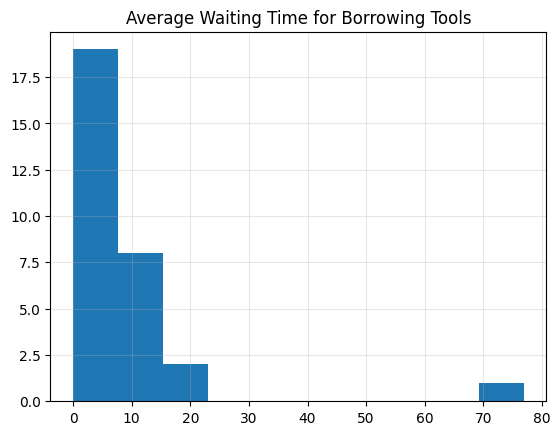

In [1038]:
# 1 - Average Waiting Time for Borrowing Tools
mean = np.mean(AWT_df.iloc[:, 0].values)
std = np.std(AWT_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
alpha = 0.05 
n = 30
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.title('Average Waiting Time for Borrowing Tools')
plt.hist(AWT_df)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 10.38
Confidence Interval Estimation: (9.83, 10.93)


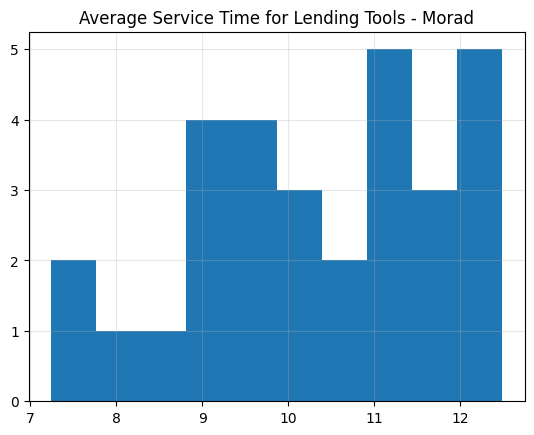

In [1065]:
# 2.1 - Average Service Time for Lending Tools - Morad
mean = np.mean(ABT_df_m.iloc[:, 0].values)
std = np.std(ABT_df_m.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Service Time for Lending Tools - Morad')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(ABT_df_m)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 13.13
Confidence Interval Estimation: (12.15, 14.12)


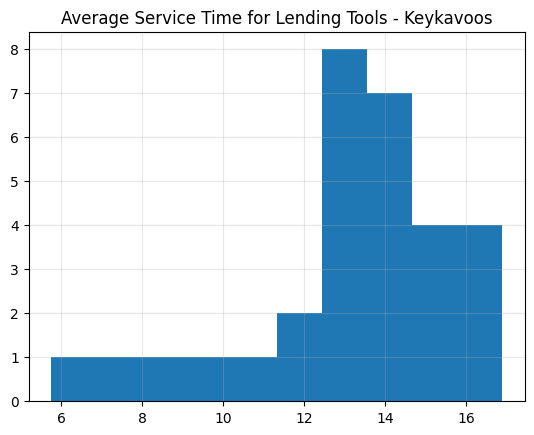

In [1066]:
# 2.2 - Average Service Time for Lending Tools - Keykavoos
mean = np.mean(ABT_df_k.iloc[:, 0].values)
std = np.std(ABT_df_k.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Service Time for Lending Tools - Keykavoos')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(ABT_df_k)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 15.98
Confidence Interval Estimation: (15.9, 16.06)


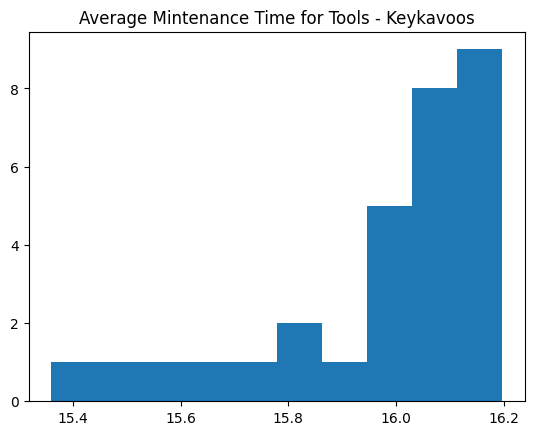

In [1033]:
# 3 - Average Mintenance Time for Tools - Keykavoos
mean = np.mean(AMT_df.iloc[:, 0].values)
std = np.std(AMT_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Mintenance Time for Tools - Keykavoos')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(AMT_df)
plt.show()

point estimation: 2.23
Confidence Interval Estimation: (1.98, 2.49)


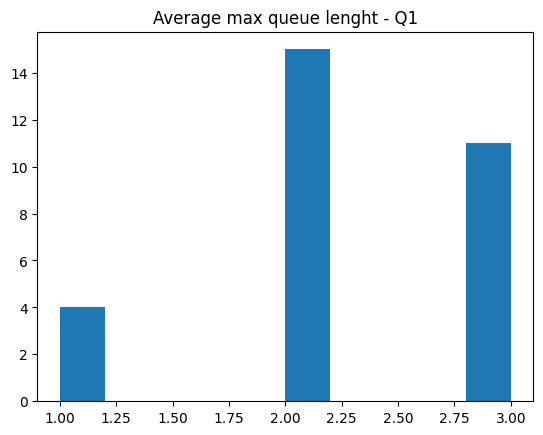

,Queue lenght
1,1.0
2,1.0
3,1.0
4,2.0
5,2.0
6,2.0
7,2.0
8,2.0
9,2.0
10,2.0


In [991]:
# 4 - Average max queue lenght
mean = np.mean(AQL_df.iloc[:, 0].values)
std = np.std(AQL_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average max queue lenght - Q1')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(AQL_df, bins = 10)
plt.show()
AQL_df

# PART C

### Changing the two servers 

In [1041]:
#Code 1
def entering_system_for_borrowing_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m  
    ML += 1
    fel.append((1, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30)))) #computing A_star (the next entering)
    sample_random = sample_random[1:]
    if Sk == 0: #enterring first server - Morad
        checker_2 = 1
        Sk = 1 
        Nk += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 14, 4)) #computing service time 
        sample_random = sample_random[1:]
        SVRk += ST #total amount of service
        ABT_lst_m.append(ST)
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return
    elif Sm == 0:
        checker_1 = 1
        Sm = 1 
        Nm += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time 
        sample_random = sample_random[1:]
        SVRm += ST #total amount of service
        ABT_lst.append(ST)
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(1) #adding to the list for computing Q2
        wait_lst.append(imn_event)  # job_type = 1 -Code-
        return

#Code 2
def entering_system_for_returning_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    MR += 1
    fel.append((2, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30)))) #computing A_star (the next entering)
    sample_random = sample_random[1:]
    if Sk == 0: #enterring first server - Morad
        checker_2 = 1
        Sk = 1 
        Nk += 1 #number of services
        ST = 2 #computing service time 
        sample_random = sample_random[1:]
        SVRk += ST #total amount of service
        fel.append((4, ST + Tnow)) #adding finish event to fel
        return
    elif Sm == 0:
        checker_1 = 1
        Sm = 1 
        Nm += 1 #number of services
        ST = 2 #computing service time 
        sample_random = sample_random[1:]
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return 
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(2) #adding to the list for computing Q2
        wait_lst.append(imn_event)  # job_type = 1 -Code-
        return

#Code 4
def service_end_keykavoos_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if checker_2 == 2:  #using checker for computing Q2
        Q2 += 1   
    if Q1 > 0:
        if checker_lst.pop(0) == 2:
            checker_2 = 2
        else:
            checker_2 = 1
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if code == 1:
            Total_wt_for_borrow += WT
            
        elif code == 2:
            Total_wt_for_return += WT
        Nk += 1 #number of services
        if code == 1:
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 14, 4)) #computing service time
            sample_random = sample_random[1:]
            ABT_lst.append(ST)
        elif code == 2:
            ST = 2
        SVRk += ST #total amount of service
        fel.append((4, ST + Tnow)) #adding finish event to fel
    else:
        Sk = 0
        return      

#Code 3    
def service_end_morad_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if checker_1 == 2:
        Q2 += 1
    if Q1 > 0:
        if checker_lst.pop(0) == 2:
            checker_1 = 2
        else:
            checker_1 = 1  
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if code == 1:
            Total_wt_for_borrow += WT
        elif code == 2:
            Total_wt_for_return += WT
        Nm += 1 #number of services
        if code == 1:
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time
            sample_random = sample_random[1:]
            ABT_lst.append(ST)
        elif code == 2:
            ST = 2
        SVRk += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel  
    elif Q2 > 0:
        Qw2 += 1 #number of people waited in line in simulation
        Q2 -= 1
        Nmw += 1
        
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
        sample_random = sample_random[1:]
        AMT_lst.append(ST)
        SVRm += ST #total amount of service
        fel.append((5, ST + Tnow)) #adding finish event to fel
    else:
        Sm = 0
        return    

#Code 5
def service_end_warehouse_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if Q2 > 0:
        Nmw += 1
        Qw2 += 1 #number of people waited in line in simulation
        Q2 -= 1
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
        sample_random = sample_random[1:]
        AMT_lst.append(ST)
        SVRm += ST #total amount of service
        fel.append((5, ST + Tnow)) #adding finish event to fel
    elif Q1 > 0:      
        if checker_lst.pop(0) == 2:
            checker_1 = 2
        else:
            checker_1 = 1  
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if code == 1:
            Total_wt_for_borrow += WT
        elif code == 2:
            Total_wt_for_return += WT
        Nk += 1 #number of services
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time
        sample_random = sample_random[1:]
        ABT_lst.append(ST)
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel'
    else:
        Sm = 0 
        return 
    
#Code 6
def service_warehouse_after_six_keykavoos_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    Nkw += 1
    Qw2 += 1 #number of people waited in line in simulation
    Q2 -= 1
    ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
    sample_random = sample_random[1:]
    SVRk += ST #total amount of service
    fel.append((6, ST + Tnow)) #adding finish event to fel
    return   

#Code 7
def service_warehouse_after_six_morad_C(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    Nmw += 1
    Qw2 += 1 #number of people waited in line in simulation
    Q2 -= 1
    ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
    sample_random = sample_random[1:]
    SVRm += ST #total amount of service
    fel.append((7, ST + Tnow)) #adding finish event to fel
    return    

In [1051]:
import time
start_time = time.time()

i = 0
Q2 = 0 #line of maintenance
p_counter = 0
MTOT_lst = []
len_queue = []

for i in range(30):
    wait_lst = [] #list for computing waiting time
    checker_lst = []
    ABT_lst_m = []
    ABT_lst_k = []
    AMT_lst = []
    Nm = 0 #number of people served by first server
    Nk = 0 #number of people served by second server
    SVRm = 0 #total service time of first server
    SVRk = 0 #total service time of second server
    Sm = 0 #state of first server
    Sk = 0 #state of second server
    Nmw = 0 #number of tools recieved by second server(morad)
    Nkw = 0 #number of tools recieved by second server(keykavoos)
    Q1 = 0 #people in queue for borrowing and returning
    Q2 = 0 #line of maintenance
    Qw = 0 #number of people waited in line in simulation
    Qw2 = 0 #number of people waited in line in simulation **********************************************************************
    TWT = 0 #total waiting time *************************************************************************************************
    ML = 0 #total people came in system for borrow
    MR = 0 #total people came in system for Returning
    history = [] #using for visualizing
    Tnow = 0
    T1 = 10 * 60 #The time of simulation
    T2 = 11 * 60 #The time everybode leavs
    Q = 0 #the number of tools in warehouse at the end of the day
    Total_wt_for_return = 0 #total waiting time in the queue for returning 
    Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 
    fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), \
           (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30))),
           (5, 0)] #initialization of FEL
    sample_random = sample_random[4:]
    Q2 = Q
    
    while True: #simulation for day {i}
        fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
        imn_event = fel.pop() #finding the imninent event
        Tnow = imn_event[1] #advancing simulation clock
        history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
        len_queue.append(Q1)
        if Tnow > T1:
            fel = []
            fel = [(6, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52)))), 
                   (7, Tnow + np.abs(normal_generator(sample_random[3], sample_random[4], 16, np.sqrt(52))))] # initialization of FEL
            sample_random = sample_random[4:]
            while True: ################################  Simulating after 6 o'clock  ################################ 
                fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
                imn_event = fel.pop() #finding the imninent event
                Tnow = imn_event[1] #advancing simulation clock
                history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
                if Tnow > T2 or Q2 == 0: #Finishing the simulation
                    Q = Q2
                    print(f'Total_wt_for_borrow: {Total_wt_for_borrow}')
                    print(f'Total_wt_for_return: {Total_wt_for_return}')
                    AWT_df.iloc[i - 1, 0] = Total_wt_for_borrow
                    if len(ABT_lst_k) > 0:
                        ABT_df_k.iloc[i-1, 0] = sum(ABT_lst_k) / len(ABT_lst_k)
                    else:
                        pass
                    if len(ABT_df_m) > 0:
                        ABT_df_m.iloc[i-1, 0] = sum(ABT_lst_m) / len(ABT_lst_m)
                    else:
                        pass
                    AMT_df.iloc[i - 1, 0] = sum(AMT_lst) / len(AMT_lst)
                    MTOT_lst.append(ML + MR)
                    break
                if imn_event[0] == 6:
                    service_warehouse_after_six_morad(Tnow, imn_event)
                elif imn_event[0] == 7:
                    service_warehouse_after_six_keykavoos(Tnow, imn_event)      

            break
        elif imn_event[0] == 1:
            entering_system_for_borrowing(Tnow, imn_event)
        elif imn_event[0] == 2:
            entering_system_for_returning(Tnow, imn_event)
        elif imn_event[0] == 3:
            service_end_morad(Tnow, imn_event)
        elif imn_event[0] == 4:
            service_end_keykavoos(Tnow, imn_event) 
        elif imn_event[0] == 5:
            service_end_warehouse(Tnow, imn_event)

end_time = time.time()
print(f'\nThe simulation took {end_time-start_time} seconds')

Total_wt_for_borrow: 1.7510774724091078
Total_wt_for_return: 17.60935623995161
Total_wt_for_borrow: 4.871934249292806
Total_wt_for_return: 0
Total_wt_for_borrow: 0.20016306214205315
Total_wt_for_return: 1.6829316493910653
Total_wt_for_borrow: 7.774943386894833
Total_wt_for_return: 10.381212244832
Total_wt_for_borrow: 9.526604916472365
Total_wt_for_return: 11.98822785770416
Total_wt_for_borrow: 0.8069540633239285
Total_wt_for_return: 15.402455769822154
Total_wt_for_borrow: 0
Total_wt_for_return: 1.6157424155889544
Total_wt_for_borrow: 0
Total_wt_for_return: 0.0514375749245346
Total_wt_for_borrow: 2.0940732401480204
Total_wt_for_return: 23.888008070309382
Total_wt_for_borrow: 5.001488144470613
Total_wt_for_return: 24.04319953312634
Total_wt_for_borrow: 4.774410240039458
Total_wt_for_return: 4.035364349969342
Total_wt_for_borrow: 0
Total_wt_for_return: 0
Total_wt_for_borrow: 0.9251163396531865
Total_wt_for_return: 5.2527592679121575
Total_wt_for_borrow: 12.068053164389426
Total_wt_for_ret

In [1052]:
print(f'The percentage of people who waited more than five minutes: {round(p_counter / sum(MTOT_lst) * 100, 2)}')

The percentage of people who waited more than five minutes: 4.61


point estimation: 7.03
Confidence Interval Estimation: (3.78, 10.29)


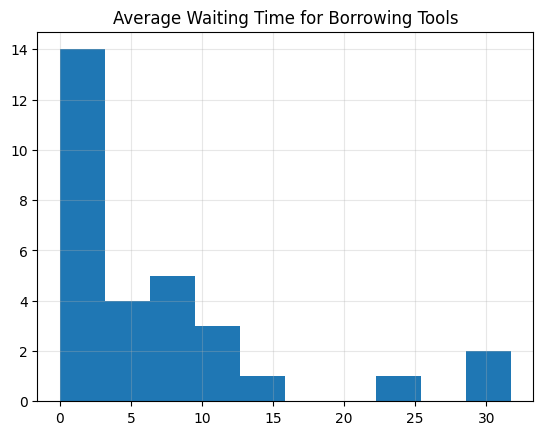

In [1053]:
# 1 - Average Waiting Time for Borrowing Tools
mean = np.mean(AWT_df.iloc[:, 0].values)
std = np.std(AWT_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
alpha = 0.05 
n = 30
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.title('Average Waiting Time for Borrowing Tools')
plt.hist(AWT_df)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 10.38
Confidence Interval Estimation: (9.83, 10.93)


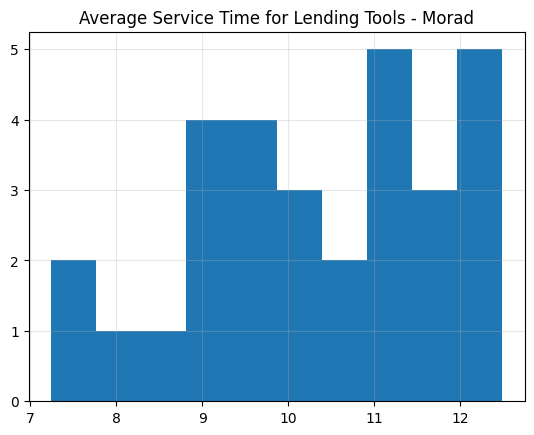

In [1054]:
# 2.1 - Average Service Time for lending Tools - Morad
mean = np.mean(ABT_df_m.iloc[:, 0].values)
std = np.std(ABT_df_m.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Service Time for Lending Tools - Morad')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(ABT_df_m)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 13.13
Confidence Interval Estimation: (12.15, 14.12)


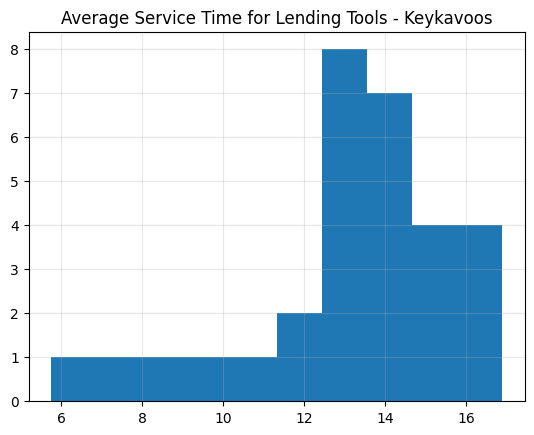

In [1055]:
# 2.2 - Average Service Time for lending Tools - Keykavoos
mean = np.mean(ABT_df_k.iloc[:, 0].values)
std = np.std(ABT_df_k.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Service Time for Lending Tools - Keykavoos')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(ABT_df_k)
plt.grid(alpha = 0.3)
plt.show()

point estimation: 16.13
Confidence Interval Estimation: (15.51, 16.76)


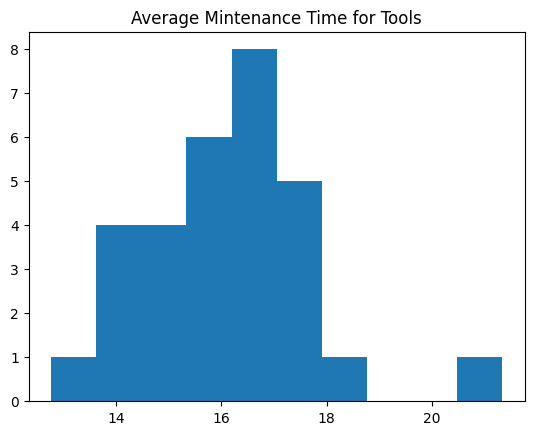

In [1003]:
# 3 - Average Mintenance Time for Tools
mean = np.mean(AMT_df.iloc[:, 0].values)
std = np.std(AMT_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average Mintenance Time for Tools')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(AMT_df)
plt.show()

point estimation: 1.9
Confidence Interval Estimation: (1.72, 2.08)


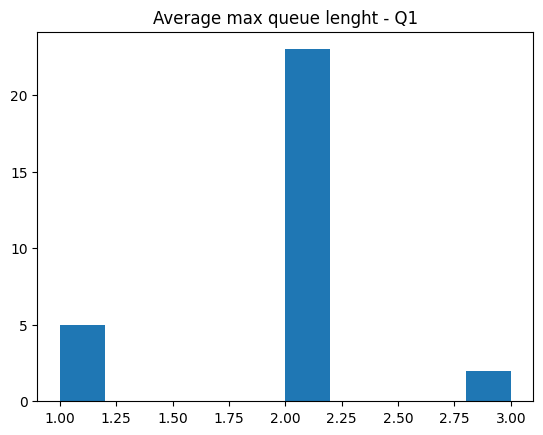

,Queue lenght
1,1.0
2,1.0
3,1.0
4,1.0
5,2.0
6,2.0
7,2.0
8,2.0
9,2.0
10,2.0


In [1056]:
# 4 - Average max queue lenght
mean = np.mean(AQL_df.iloc[:, 0].values)
std = np.std(AQL_df.iloc[:, 0].values, ddof = 1) #it's sample -> ddof = 1
n = 30
alpha = 0.05 
df = n - 1 
t_critical = t.ppf(1 - alpha/2, df)
lower = mean - t_critical * std / np.sqrt(n)
upper = mean + t_critical * std / np.sqrt(n)
plt.title('Average max queue lenght - Q1')
print(f'point estimation: {round(mean, 2)}')
print(f'Confidence Interval Estimation: ({round(lower, 2)}, {round(upper, 2)})')  
plt.hist(AQL_df, bins = 10)
plt.show()
AQL_df

# Improving the system

In [848]:
wait_lst = [] #list for computing waiting time
Nm = 0 #number of people served by first server
Nk = 0 #number of people served by second server
SVRm = 0 #total service time of first server
SVRk = 0 #total service time of second server
Sm = 0 #state of first server
Sk = 0 #state of second server
Nmw = 0 #number of tools recieved by second server(morad)
Nkw = 0 #number of tools recieved by second server(keykavoos)
Q1 = 0 #people in queue for borrowing and returning
Q2 = 0 #line of maintenance
Qw = 0 #number of people waited in line_1 in simulation
Qw2 = 0 #number of people waited in line_2 in simulation 
TWT = 0 #total waiting time 
ML = 0 #total people came in system for borrow
MR = 0 #total people came in system for Returning
history = [] #using for visualizing
Tnow = 0
T1 = 10 * 60 #The time of simulation
T2 = 11 * 60 #The time everybode leavs
Q = 0 #the number of tools in warehouse at the end of the day
Total_wt_for_return = 0 #total waiting time in the queue for returning 
Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 

checker_lst = []

In [846]:
fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), \
       (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30)))] #initialization of FEL
sample_random = sample_random[2:]
fel

[(1, 40.79860172578651), (2, 22.550260723992402)]

In [1062]:
#Code 1
def enter_borrow(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    fel.append((1, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))))
    sample_random = sample_random[1:]
    if Sm == 0:
        checker_1 = 1
        Nm += 1 #number of services
        Sm = 1
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time
        sample_random = sample_random[1:]
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(1) #adding to the list for computing Q2
        wait_lst.append(imn_event)  # job_type = 1 -Code-
        return

#Code 2
def enter_return(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    fel .append((2, Tnow + np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))))
    sample_random = sample_random[1:]
    if Sm == 0:
        checker_1 = 2
        Nm += 1 #number of services
        Sm = 1
        ST = 2 #computing service time
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    else:
        Q1 += 1 #adding to the queque
        checker_lst.append(2) #adding to the list for computing Q2
        wait_lst.append(imn_event)  # job_type = 1 -Code-
        return
    
#Code 3
def fin_ser_morad(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if checker_1 == 2:  #using checker for computing Q2
        if Sk == 0:
            Sk = 1
            Nk += 1
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
            sample_random = sample_random[1:] 
            SVRk += ST #total amount of service
            fel.append((4, ST + Tnow)) #adding finish event to fel
        else:
            Q2 += 1
    if Q1 > 0:
        if checker_lst.pop(0) == 2:
            checker_1 = 2
        else:
            checker_1 = 1
        Qw += 1 #number of people waited in line in simulation
        Q1 -= 1
        Nm += 1 #number of services
        WT = Tnow - wait_lst[0][1]
        code = wait_lst[0][0]
        wait_lst.pop(0)
        TWT += WT
        if code == 1:
            Total_wt_for_borrow += WT
        elif code == 2:
            Total_wt_for_return += WT
        if code == 1:
            ST = np.abs(normal_generator(sample_random[1], sample_random[2], 10, 5)) #computing service time
            sample_random = sample_random[1:]
        elif code == 2:
            ST = 2
        SVRm += ST #total amount of service
        fel.append((3, ST + Tnow)) #adding finish event to fel
        return
    else:
        Sm = 0
        return
    
#Code 4
def fin_ser_keykavoos(Tnow, imn_event):
    global fel, Nm, Nk, Nkw, Nmw, SVRm, SVRk, Sm, Sk, Q1, Q2, Q, Qw, Qw2, TWT, ML, MR, p_counter, \
    history, T1, T2, Total_wt_for_borrow, Total_wt_for_return, sample_random, checker_1, checker_2, \
    checker_lst, ABT_lst_k, ABT_lst_m
    if Q2 > 0:
        Q2 -= 1
        Qw2 += 1 #number of people waited in line in simulation
        Nk += 1
        ST = np.abs(normal_generator(sample_random[1], sample_random[2], 16, np.sqrt(52))) #computing service time
        sample_random = sample_random[1:] 
        SVRk += ST #total amount of service
        fel.append((4, ST + Tnow)) #adding finish event to fel
    else:
        Sk = 0

In [1064]:
p_counter = 0
wait_lst = [] #list for computing waiting time
checker_lst = []
ABT_lst = []
AMT_lst = []
len_queue = []
Nm = 0 #number of people served by first server
Nk = 0 #number of people served by second server
SVRm = 0 #total service time of first server
SVRk = 0 #total service time of second server
Sm = 0 #state of first server
Sk = 0 #state of second server
Nmw = 0 #number of tools recieved by second server(morad)
Nkw = 0 #number of tools recieved by second server(keykavoos)
Q1 = 0 #people in queue for borrowing and returning
Q2 = 0 #line of maintenance
Qw = 0 #number of people waited in line in simulation
Qw2 = 0 #number of people waited in line in simulation 
TWT = 0 #total waiting time 
ML = 0 #total people came in system for borrow
MR = 0 #total people came in system for Returning
history = [] #using for visualizing
Tnow = 0
T1 = 10 * 60 #The time of simulation
T2 = 11 * 60 #The time everybode leavs
Q = 0 #the number of tools in warehouse at the end of the day
Total_wt_for_return = 0 #total waiting time in the queue for returning 
Total_wt_for_borrow = 0 #total waiting in the queue for borrowing 

i = 1
import time
start_time = time.time()

fel = [(1, np.abs(normal_generator(sample_random[1], sample_random[2], 30, 30))), \
       (2, np.abs(normal_generator(sample_random[3], sample_random[4], 30, 30)))] #initialization of FEL
sample_random = sample_random[4:]
while True: #starting the simulation
    fel.sort(key = lambda x:x[1], reverse = True) #sorting the FEL
    imn_event = fel.pop() #finding the imninent event
    Tnow = imn_event[1] #advancing simulation clock
    len_queue.append(Q1) #computing max len queue
    history.append((Tnow, Q1, Q2, Sm, Sk)) #stacking the variables for the plots
    if Tnow > T1: #simulation after 6 o'clock
        print(f'The maximum people in queue: {max(len_queue)}')
        print(f'Waiting Time for Borrowing Tools: {round(Total_wt_for_borrow, 2)}')
        break
        
    elif imn_event[0] == 1:
        enter_borrow(Tnow, imn_event)
    elif imn_event[0] == 2:
        enter_return(Tnow, imn_event)
    elif imn_event[0] == 3:
        fin_ser_morad(Tnow, imn_event)
    elif imn_event[0] == 4:
        fin_ser_keykavoos(Tnow, imn_event) 

end_time = time.time()
print(f'\nThe simulation took {end_time-start_time} seconds')

The maximum people in queue: 2
Waiting Time for Borrowing Tools: 13.1

The simulation took 2.481086254119873 seconds


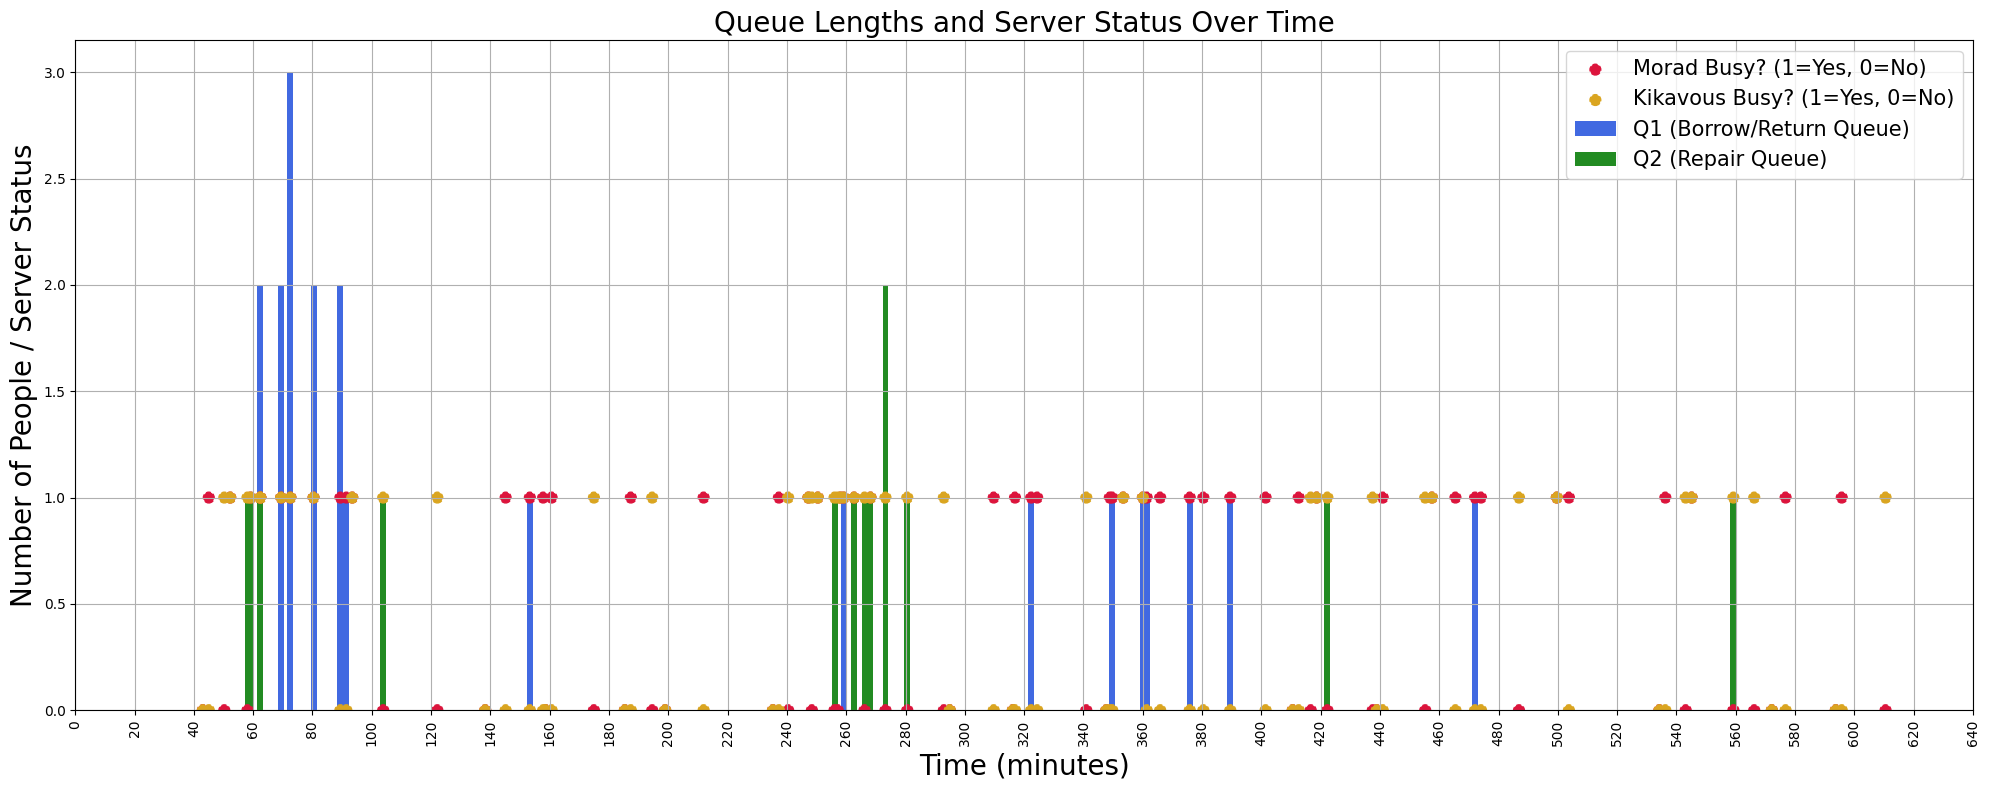

In [1058]:
import matplotlib.pyplot as plt
# Extracting values from history
times = [h[0] for h in history]
q1_list = [h[1] for h in history]
q2_list = [h[2] for h in history]
sm_list = [h[3] for h in history]
sk_list = [h[4] for h in history]

plt.figure(figsize=(20, 8))
plt.bar(times, q1_list, label = "Q1 (Borrow/Return Queue)", color = "RoyalBlue", width = 2, alpha = 1)
plt.bar(times, q2_list, label = "Q2 (Repair Queue)", color = "forestgreen", width = 2, alpha = 1)
plt.scatter(times, sm_list, label = "Morad Busy? (1=Yes, 0=No)", color = "crimson", linestyle = "--", s = 60)
plt.scatter(times, sk_list, label = "Kikavous Busy? (1=Yes, 0=No)", color = "goldenrod", linestyle = "--", s = 60)
plt.xlabel("Time (minutes)", fontsize = 20)
plt.xticks(ticks = range(0, 650, 20),
           labels = range(0, 650, 20),
           rotation = 90)
plt.ylabel("Number of People / Server Status", fontsize = 20)
plt.title("Queue Lengths and Server Status Over Time", fontsize = 20)
plt.legend(fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.show()

# End of Code